In [1]:
# For downloading data
import sxs

# For interacting with the data
import h5py
import numpy as np
from matplotlib import pyplot as plt
import json
import pandas as pd

#Other libraries
from lmfit import Model, minimize, Parameters
import qnm
import torch
from torch.optim import LBFGS

In [23]:
#Initializing arrays that will be used for the fitting function
waveforms = []
names = []
spins = []
masses = []

#Loop through the entire SXS BBH catalog
for i in range(20):
    #Catch exception block is here because I didnt want to check how many BBH simulations there are, I know its over 2265, so I put 2300.
    try:
        #Change the format of i from say, 1 to 0001 as the SXS BBH catalog has its files names in that format
        i = '{0:04}'.format(i)

        #Load the metadata to get the spin and mass information, spin is most important right now
        mtdt = sxs.load(f"SXS:BBH:{i}/Lev/metadata.json", download = False)
        spin = mtdt.remnant_dimensionless_spin[2]
        mass = mtdt.remnant_mass
        
        #Most of the BBHs with random spin orientations will converge to Chi = 0.69, which is what we're looking for to compare the overtone numbers.
        if 0.65 <= spin <= 0.75:
            #If the spin matches, then load the large waveform rhOVerM file, it will download if not already stored locally and each is about 80-100 mb
            #Store all the information of masses, spins, etc to the arrays
            names.append(i)
            spins.append(spin)
            masses.append(mass)
            w = sxs.load(f"SXS:BBH:{i}/Lev/rhOverM", extrapolation_order=2, download = False)
            waveforms.append(w)
    except:
        pass

Found the following files to load from the SXS catalog:
    SXS:BBH:0001v6/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0001v6/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0002v7/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0002v7/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0003v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0003v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0004v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0005v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0006v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0007v

In [24]:
waveforms[0]

WaveformModes([[ 4.35110689e-04-1.02152370e-03j, -4.74434117e-11-4.62757493e-11j,
        -2.81759814e-04-8.52883891e-14j, ...,
        -1.63744585e-09-5.20794761e-09j, -1.64269946e-11-6.08956676e-12j,
         5.56348847e-09-2.23973035e-09j],
       [ 4.36959709e-04-1.01562374e-03j, -5.74582748e-11-7.32078466e-11j,
        -2.81701470e-04-7.71392193e-14j, ...,
        -5.69803980e-09-4.43587738e-09j, -1.25355325e-11-1.21912076e-11j,
         6.30718621e-09-5.22775633e-09j],
       [ 4.38714027e-04-1.00972466e-03j, -5.92874398e-11-1.01867763e-10j,
        -2.81636597e-04-6.57034437e-14j, ...,
        -9.73881877e-09-3.03849891e-09j, -7.53617199e-12-1.54345605e-11j,
         6.74719571e-09-7.61488992e-09j],
       ...,
       [ 3.56009715e-04+2.07644218e-04j,  3.05168629e-11+2.86534942e-10j,
        -6.34810242e-05+2.84932509e-11j, ...,
        -5.53228491e-08+1.82724965e-07j,  6.71970901e-11+5.03004739e-11j,
         3.19352273e-08-1.43993117e-06j],
       [ 3.56013247e-04+2.07926907e-

In [25]:
# Initialize an empty list to store the final result
all_omega = []

# Loop over all spins
for j in range(len(spins)):
    # Initialize an empty list to store the freq values for this spin
    omega = []
    
    # Loop over all overtones
    for i in range(8):
        # Calculate the grav_220 mode for this overtone
        grav_220 = qnm.modes_cache(s=-2,l=2,m=2,n=i)
        
        # Calculate the freq, A, and B values for this spin and overtone
        freq, A, B = grav_220(a=spins[j])
        
        # Append the freq value to the omega list
        omega.append(freq)
    
    # Append the omega list for this spin to the all_omega list
    all_omega.append(omega)

In [26]:
# Convert the all_omega list to a pandas DataFrame
qnmFreq_df = pd.DataFrame(all_omega, columns=[f'N={i}' for i in range(8)])
qnmFreq_df.insert(0, "Name", names)
qnmFreq_df.insert(1, "Spin", spins)
qnmFreq_df.insert(2, "Remnant Mass", masses)

In [27]:
qnmFreq_df

,Name,Spin,Remnant Mass,N=0,N=1,N=2,N=3,N=4,N=5,N=6,N=7
0,0001,0.686462,0.951609,0.526704-0.081288j,0.514860-0.245813j,0.492964-0.415136j,0.463866-0.588731j,0.432914-0.760352j,0.415548-0.927633j,0.414827-1.107500j,0.415936-1.301166j
1,0002,0.686448,0.951610,0.526698-0.081289j,0.514853-0.245815j,0.492957-0.415139j,0.463859-0.588736j,0.432906-0.760358j,0.415540-0.927643j,0.414818-1.107512j,0.415926-1.301179j
2,0003,0.691447,0.951083,0.528846-0.081110j,0.517150-0.245245j,0.495488-0.414097j,0.466582-0.587123j,0.435638-0.757964j,0.418439-0.924115j,0.418123-1.103112j,0.419441-1.296070j
3,0007,0.664091,0.955270,0.517478-0.082034j,0.504985-0.248199j,0.482071-0.419546j,0.452136-0.595644j,0.421057-0.770712j,0.402856-0.942781j,0.400411-1.126329j,0.400630-1.323009j
4,0008,0.664091,0.955267,0.517478-0.082034j,0.504985-0.248199j,0.482071-0.419546j,0.452136-0.595644j,0.421057-0.770713j,0.402855-0.942781j,0.400410-1.126329j,0.400630-1.323009j
5,0015,0.674831,0.954807,0.521831-0.081687j,0.509646-0.247085j,0.487216-0.417478j,0.457677-0.592385j,0.426678-0.765809j,0.408893-0.935635j,0.407257-1.117459j,0.407895-1.312724j
6,0017,0.678118,0.954713,0.523191-0.081577j,0.511102-0.246733j,0.488821-0.416827j,0.459406-0.591366j,0.428424-0.764282j,0.410761-0.933402j,0.409379-1.114683j,0.410149-1.309502j
7,0018,0.674799,0.954800,0.521817-0.081688j,0.509632-0.247089j,0.487200-0.417484j,0.457661-0.592395j,0.426661-0.765823j,0.408875-0.935656j,0.407236-1.117486j,0.407873-1.312755j


In [28]:
only_wav = [row[1] for row in waveforms]

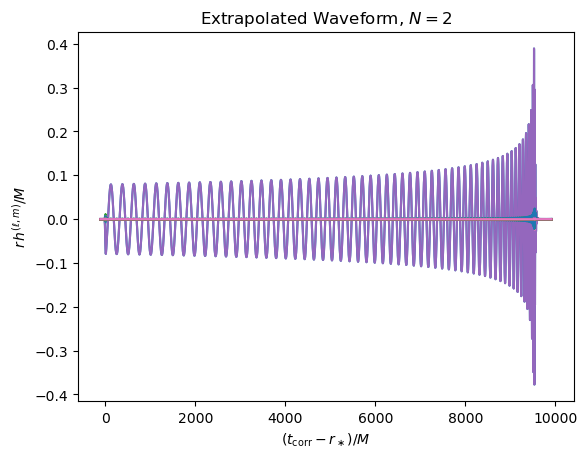

In [29]:
w1 = waveforms[0]
extrapolation_order = 2
plt.plot(w1.t, w1.data.real)
plt.title(f"Extrapolated Waveform, $N={extrapolation_order}$")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$r\, h^{(\ell,m)}/M$")
plt.show()

In [8]:
import torch
from torch.optim import LBFGS

In [10]:
T = 0
t_0 = w.max_norm_time() + T

# Calculate omega array using a list comprehension
omega = np.asarray([qnm.modes_cache(s=-2, l=2, m=2, n=i)(a=spin)[0] for i in range(8)])

# Calculate dimensionless qnm frequency
freq = omega / mass

# Assuming 'w' is your waveform data and is already a PyTorch tensor
# Move data to GPU
w = w.to('cuda')

# Define the model parameters and move them to GPU
params = {'C': torch.zeros(8, device='cuda', requires_grad=True),
          'phi': torch.zeros(8, device='cuda', requires_grad=True),
          'const': torch.tensor(0., device='cuda', requires_grad=True)}

# Define the h function using PyTorch operations
def h(params, t):
    h_s = [params['C'][i] * torch.exp(-1j * (freq[i] * (t - t_0) + params['phi'][i])) for i in range(len(freq))]
    h_s.append(params['const'])
    return sum(h_s)




ModuleNotFoundError: No module named 'torch'

In [ ]:
# Define the optimization function
def funcBoth(params, t, data):
    # ... similar to your existing function, but using PyTorch operations ...

# Set up the optimizer
optimizer = LBFGS(params.values(), lr=1)

# Define the optimization step
def closure():
    optimizer.zero_grad()
    output = funcBoth(params, tdata, wdata)
    loss = output.norm()  # Or another appropriate loss function
    loss.backward()
    return loss



# Perform the optimization
for _ in range(num_iterations):
    optimizer.step(closure)

# Extract the optimized parameters
optimized_params = {name: param.detach().cpu().numpy() for name, param in params.items()}